### Running PESTPP-IES

In [37]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

import pyemu
import flopy
# assert "dependencies" in flopy.__file__
# assert "dependencies" in pyemu.__file__
# sys.path.insert(0,"..")
import herebedragons as hbd

In [38]:
# specify the temporary working folder
t_d = os.path.join('pst_template_ies')
# get the previously generated PEST dataset
org_t_d = os.path.join("pst_template_pmc")
if not os.path.exists(org_t_d):
    raise Exception()
if os.path.exists(t_d):
    shutil.rmtree(t_d)
shutil.copytree(org_t_d,t_d)

'pst_template_ies'

In [39]:
pst_path = os.path.join(t_d, 'pest.pst')
pst = pyemu.Pst(pst_path)

In [40]:
# check to see if obs&weights notebook has been run
if not pst.nnz_obs > 0:
    raise Exception()

Here we show some nice PESTPP-IES little tricks:

- <code>ies_bad_phi_sigma</code>: realizations marked as “bad” if its objective function is much worse than the ensemble average, with the cutoff set by the standard deviation scaled by this number
- <code>ies_multimodel_alpha</code>: The fraction of the total ensemble size to use as the local neighborhood realizations in the multimodal solution process.
- <code>ies_n_iter_reinflate</code>: The number of between covariance re-inflation

<font color="#ff7700ff">
Acá van unos trucos de <code>PESTPP-IES</code>:

- <code>ies_bad_phi_sigma</code>: marca una realización como "mala" si su función objetivo es mucho peor que el promedio del ensemble, usando el desvío estándar escalado por este número.
- <code>ies_multimodel_alpha</code>: la fracción del ensemble total que se usa como vecindad local en el proceso multimodal.
- <code>ies_n_iter_reinflate</code>: el número de veces que se reinfla la covarianza entre iteraciones.
</font>

In [41]:
pst.pestpp_options["ies_num_reals"] = 100
pst.pestpp_options["ies_bad_phi_sigma"] = 1.75
pst.pestpp_options["ies_multimodal_alpha"] = 0.99

## Observation noise



In [42]:
obs = pst.observation_data
obs["standard_deviation"] = np.nan
nzobs = obs.loc[obs.weight>0,:].copy()
obs.loc[nzobs.obsnme,"standard_deviation"] = 0.33
dobs = nzobs.loc[nzobs.obsnme.str.contains("gde"),:]
assert dobs.shape[0] == 1
obs.loc[dobs.obsnme,"standard_deviation"] = dobs.obsval * 0.2
nzobs = obs.loc[obs.weight>0,:].copy()
np.random.seed(pyemu.en.SEED)
draws = np.random.normal(0.0,1.0,pst.pestpp_options["ies_num_reals"])
vals = nzobs.obsval.values
stdevs = nzobs.standard_deviation.values
noisyobs = []
for i,d in enumerate(draws):
    noise = d * stdevs
    noisyobs.append(vals+noise)
df = pd.DataFrame(noisyobs,index=np.arange(pst.pestpp_options["ies_num_reals"]),columns=nzobs.obsnme)
df.to_csv(os.path.join(t_d,"corrnoise.csv"))
pst.pestpp_options["ies_obs_en"] = "corrnoise.csv"
    

Let's run PESTPP-IES with noptmax -2. This will calculate the mean value of the initial parameter ensemble, evaluate it (by running the model once) and record the results

<font color="#ff7700ff">
Corramos <code>PESTPP-IES</code> con <code>noptmax = -2</code>. Esto calcula el valor medio del ensemble inicial de parámetros, lo evalúa (corriendo el modelo una vez) y guarda los resultados.
</font>

In [43]:
pst.control_data.noptmax = -2 
pst.write(os.path.join(t_d, 'pest.pst'),version=2)

pyemu.os_utils.run("pestpp-ies pest.pst",cwd=t_d)

noptmax:-2, npar_adj:506, nnz_obs:51
./pestpp-ies pest.pst


             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.23
binary compiled on Aug 26 2025 at 11:34:36

started at 09/01/25 12:08:22
...processing command line: ' ./pestpp-ies pest.pst'
...using serial run manager

using control file: "pest.pst"
in directory: "/Users/portega/dev/code/gmdsi-workshop-chile2025/tutorials/pst_template_ies"
on host: "windrunner"

processing control file pest.pst
checking model IO files...done
              starting serial run manager ...


  ---  initializing  ---  
...using glm algorithm
...using REDSVD for truncated svd solve
...maxsing: 10000000
...eigthresh:  1e-06
...initializing localizer
...not using localization
...using lambda multipliers: 0.1 , 1 , 10 , 
...using lambda scaling factors: 0.75 , 1 , 1.1 , 
...acceptable phi factor:  1.05
...lambda increase factor:  10
...lambda decrease factor:  0.75
...max run fail:  1
..

## Let's do some more weighting adjustments

The `ies_phi_factor_file` option turns on internal weight adjustment. It points to a file with two columns and no header (comma or space delimited).

Column 1: a tag used to match observation groups by substring. This lets you combine multiple groups into one “weighting group.”

Column 2: a positive number (phi factor) that sets what share of the current measurement phi that group should take.

Here we have two groups, hds and drn, and we will split the contribution as 50% each.

<font color="#ff7700ff">
La opción <code>ies_phi_factor_file</code> activa el ajuste interno de pesos. Apunta a un archivo con dos columnas y sin encabezado (separado por coma o espacio).

Columna 1: una etiqueta que se usa para buscar grupos de observaciones por subcadena. Así puedes combinar varios grupos en un solo "grupo de pesos".

Columna 2: un número positivo (<code>phi factor</code>) que define qué proporción del phi de medición actual debe tomar ese grupo.

En este caso le vamos a dar 50 y 50 a los grupos drn y hds.
</font>

In [44]:
with open(os.path.join(t_d,"phi.csv"),'w') as f:
    f.write("hds,0.5\n")
    f.write("drn,0.5\n")
pst.pestpp_options["ies_phi_factor_file"] = "phi.csv"

In [45]:
pst.control_data.noptmax = -2
pst.write(os.path.join(t_d, 'pest.pst'),version=2)

pyemu.os_utils.run("pestpp-ies pest.pst",cwd=t_d)

noptmax:-2, npar_adj:506, nnz_obs:51
./pestpp-ies pest.pst


             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.23
binary compiled on Aug 26 2025 at 11:34:36

started at 09/01/25 12:08:28
...processing command line: ' ./pestpp-ies pest.pst'
...using serial run manager

using control file: "pest.pst"
in directory: "/Users/portega/dev/code/gmdsi-workshop-chile2025/tutorials/pst_template_ies"
on host: "windrunner"

processing control file pest.pst
checking model IO files...done
              starting serial run manager ...


  ---  initializing  ---  
...checking phi factors in file phi.csv
...using glm algorithm
...using REDSVD for truncated svd solve
...maxsing: 10000000
...eigthresh:  1e-06
...initializing localizer
...not using localization
...using lambda multipliers: 0.1 , 1 , 10 , 
...using lambda scaling factors: 0.75 , 1 , 1.1 , 
...acceptable phi factor:  1.05
...lambda increase factor:  10
...lambda decre

# For the Win!

In [46]:
pst.control_data.noptmax = 3
pst.write(os.path.join(t_d, 'pest.pst'),version=2)

noptmax:3, npar_adj:506, nnz_obs:51


In [ ]:
num_workers = 15
m_d = "master_ies0"

In [48]:
pyemu.os_utils.start_workers(t_d, # the folder which contains the "template" PEST dataset
                            'pestpp-ies', #the PEST software version we want to run
                            'pest.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )

2025-09-01 12:08:32,954 - MainProcess - INFO - Reserved port 4105 for process 72156




             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.23
binary compiled on Aug 26 2025 at 11:34:36

started at 09/01/25 12:08:33
...processing command line: ' ./pestpp-ies pest.pst /h :4105'
...using panther run manager in master mode using port 4105

using control file: "pest.pst"
in directory: "/Users/portega/dev/code/gmdsi-workshop-chile2025/tutorials/master_ies0"
on host: "windrunner"

processing control file pest.pst


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... ..  .:::::.     . ..:::::::....:::.  `: .'
    :..    ____:::::::::.  . . ....:::::::::____  ... :
   :... `:~    ^~-:::::..  .....

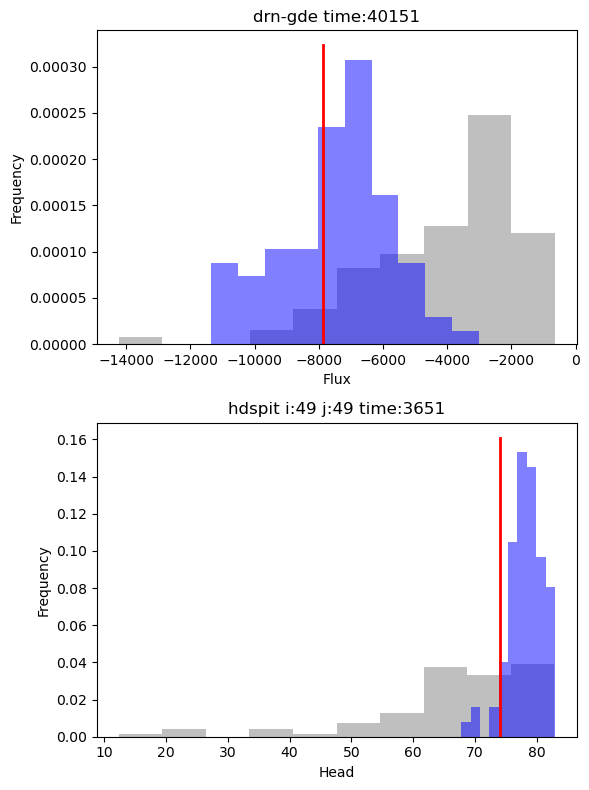

In [79]:
pst = pyemu.Pst(os.path.join(m_d,"pest.pst"))
obs = pst.observation_data
oe_pr = pst.ies.obsen0
oe_pt = pst.ies.get("obsen",pst.ies.phiactual.iteration.max())
forecasts = pst.pestpp_options["forecasts"].split(",")
fig, axs = plt.subplots(len(forecasts),1,figsize=(6,8))
for f, ax in zip(forecasts, axs):
    oe_pr.loc[:,f].plot(kind="hist",fc="0.5",alpha=0.5,density=True, ax=ax)
    oe_pt.loc[:,f].plot(kind="hist",fc="b",alpha=0.5,density=True, ax=ax)
    ylim = ax.get_ylim()
    v = obs.loc[f,"obsval"]
    ax.plot([v,v],ylim,"r-",lw=2)
    ax.set_title(' '.join(f.split("usecol:")[-1].split("_")))
axs[0].set_xlabel("Flux")
axs[-1].set_xlabel("Head")
plt.tight_layout()

In [50]:
hkobs = obs.loc[obs.oname=="hk",:].copy()
hkobs["i"] = hkobs.i.astype(int)
hkobs["j"] = hkobs.j.astype(int)


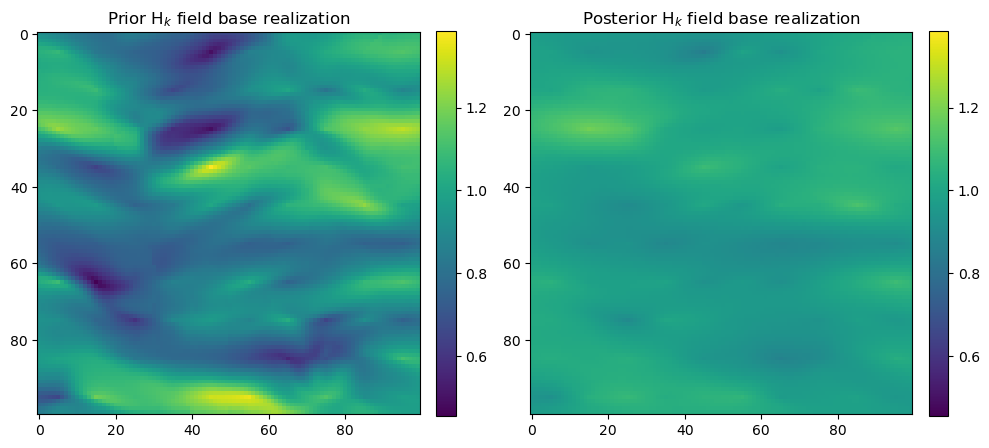

In [64]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
prarr = np.zeros((hkobs.i.max()+1,hkobs.j.max()+1))
prarr[hkobs.i,hkobs.j] = np.log10(oe_pr.loc["base",
                                            hkobs.obsnme])
ptarr = np.zeros((hkobs.i.max()+1,hkobs.j.max()+1))
ptarr[hkobs.i,hkobs.j] = np.log10(oe_pt.loc["base",
                                            hkobs.obsnme])
vmin = min(prarr.min(),ptarr.min())
vmax = max(prarr.max(),ptarr.max())

# print(ptarr.max())
# print(prarr.min())
# print(vmin,vmax)
cb = axes[0].imshow(prarr, vmin=vmin, vmax=vmax)
axes[0].set_title("Prior H$_k$ field base realization")
plt.colorbar(cb,ax=axes[0], fraction=0.046, pad=0.04)
cb = axes[1].imshow(ptarr, vmin=vmin, vmax=vmax)
axes[1].set_title("Posterior H$_k$ field base realization")
plt.colorbar(cb,ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()

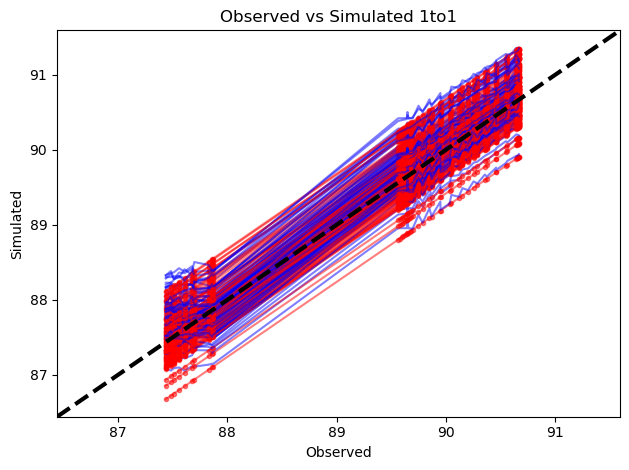

In [66]:
fig,ax = plt.subplots(1,1)
noise = pst.ies.noise
hobs = obs.loc[(~obs.obsnme.str.contains("gde")) & (obs.weight>0),:]
hobs.sort_values(by="obsval",inplace=True)
hvals = hobs.obsval.values
for real in oe_pt.index:
    vals = noise.loc[real,hobs.obsnme].values
    ax.plot(hvals,vals,"r-",marker=".",alpha=0.5)
#     vals = oe_pr.loc[real,hobs.obsnme].values
#     ax.plot(hvals, 
#             vals,
#             "0.5",
#             # marker=".",
#             alpha=0.5)
    vals = oe_pt.loc[real,hobs.obsnme].values
    ax.plot(hvals, 
            vals,
            "b",
            # marker=".",
            alpha=0.5,
            )

xlim = ax.get_xlim()
ylim = ax.get_ylim()
mn = min(xlim[0],ylim[0])
mx = max(xlim[1],ylim[1])
ax.plot([mn,mx], [mn,mx], "k--", lw=3)
ax.set_xlim(mn,mx)
ax.set_ylim(mn,mx)
ax.set_xlabel("Observed")
ax.set_ylabel("Simulated")
ax.set_title("Observed vs Simulated 1to1")

plt.tight_layout()

    